In [21]:
import itertools
import json
import os

import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline


dataset = '../dns_final.csv'
anchor_file = '../anchor.csv'
map_file = '../mapping.json'
reports = '../virustotal/data/reports/'
colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

In [22]:
df = pd.read_csv(dataset)
anchor = pd.read_csv(anchor_file)
with open(map_file) as f:
    mapping = json.load(f)
    rev_mapping = {y:x for x, y in mapping.items()}

In [23]:
# window size is 50, so use 46 real and seed with 4
def generate_random_sample():
    df_sample = np.random.choice(df.index.values, 240)
    s1 = df.ix[df_sample]
    ar = np.array(s1)
    anchor_sample = np.random.choice(anchor.index.values, 10)
    s2 = anchor.ix[anchor_sample]
    ar = np.concatenate((ar, np.array(s2)), axis=0)
    return (ar, s1, s2)

def get_report(name):
    n = os.path.join(reports, name) + '.json'
    try:
        with open(n) as f:
            r = json.load(f)
        return r['positives']
    except:
        return -1

def determine_accuracy(ar, s1, s2, labels):
    # assumes df, anchor, and mapping are globals that exist
    # we know the last n rows in ar are the seeds
    # first, we assume the n seeds should be clustered together
    if (labels[-1] != labels[-2]) or (labels[-1] != labels[-3]) or (labels[-1] != labels[-4]) or \
        (labels[-2] != labels[-3]) or (labels[-2] != labels[-4]) or (labels[-3] != labels[-4]):
        raise Exception('Seeds were not clustered together')
    indexes = np.where((labels[:-4] == labels[-1]))
    possible = s1.iloc[indexes]
    #display(possible.head())
    display('There are {} total entries in the "bad" cluster out of the 46 possible.'.format(len(possible)))
    s1['DNAME'] = s1['NAME'].map(lambda x: rev_mapping[x])
    s1['SCORE'] = s1['DNAME'].map(get_report)
    pos = len(s1[s1['SCORE'] > 0])
    display('Ignoring the seeds, there are {}/{} possibly malicious domains in the cluster'.format(pos, len(possible)))

## Generate random sample

In [24]:
# Column reference
# ['QR', 'OPCODE', 'QNAME', 'QTYPE', 'QCLS', 'RRTYPE', 'RCLS', 'TTL',
#  'RLEN', 'AA', 'ID', 'QDCNT', 'ANCNT', 'NSCNT', 'ARCNT', 'NAME_ENTROPY', 'DATA_ENTROPY']
ar, s1, s2 = generate_random_sample()

# Affinity Propagation

In [25]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation().fit(ar)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

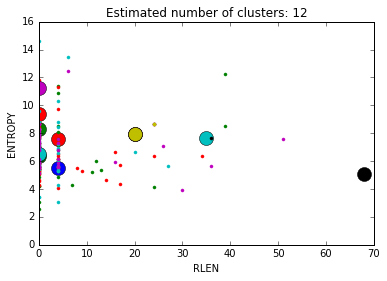

In [26]:
# separate plotting code for graphing different columns against each other
plt.close('all')
plt.figure(1)
plt.clf()

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = ar[cluster_centers_indices[k]]
    plt.plot(ar[class_members, 8], ar[class_members, 15], col + '.')
    plt.plot(cluster_center[8], cluster_center[15], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in ar[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('RLEN')
plt.ylabel('ENTROPY')
plt.show()

In [ ]:
try:
    determine_accuracy(ar, s1, s2, labels)
except Exception as e:
    display(str(e))

# Mean Shift

In [27]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(ar, quantile=0.5)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(ar)

# matches with row numbers in the nparray
labels = ms.labels_
# each nparray matches up with the df columns
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

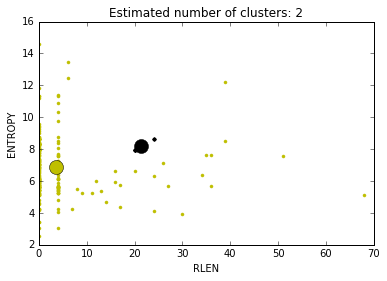

In [28]:
# separate plotting code for graphing different columns against each other
plt.figure(1)
plt.clf()

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(ar[my_members, 8], ar[my_members, 15], col + '.')
    plt.plot(cluster_center[8], cluster_center[15], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('RLEN')
plt.ylabel('ENTROPY')
plt.show()

In [ ]:
try:
    determine_accuracy(ar, s1, s2, labels)
except Exception as e:
    display(str(e))

# K-means

In [29]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2).fit(ar)
# matches with row numbers in the nparray
labels = km.labels_
# each nparray matches up with the df columns
cluster_centers = km.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

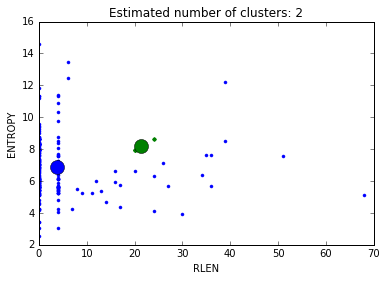

In [30]:
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(ar[my_members, 8], ar[my_members, 15], col + '.')
    plt.plot(cluster_center[8], cluster_center[15], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('RLEN')
plt.ylabel('ENTROPY')
plt.show()

In [ ]:
try:
    determine_accuracy(ar, s1, s2, labels)
except Exception as e:
    display(str(e))